# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [3]:
import warnings

import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import catboost as cb

import lightgbm as ltb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial

from sklearn.metrics import mean_squared_error

# import shap

In [4]:
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format

sns.set_theme(rc={'figure.figsize':(12,9)})

PATH_MY = 'data/autos.csv'
PATH_YAP = '/datasets/autos.csv'

In [5]:
%%html
<style>
table {float:left}
</style>

In [6]:
try:
    df = pd.read_csv(PATH_MY)
except:
    df = pd.read_csv(PATH_YAP)

In [7]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Описание данных**

|Column|Description|
|:----------|:----------------------------|
|**DateCrawled**|дата скачивания анкеты из базы
|**Price**|цена (евро) <<--**ЦЕЛЕВОЙ ПРИЗНАК**
|**VehicleType**|тип автомобильного кузова
|**RegistrationYear**|год регистрации автомобиля
|**Gearbox**|тип коробки передач
|**Power**|мощность (л. с.)
|**Model**|модель автомобиля
|**Kilometer**|пробег (км)
|**RegistrationMonth**|месяц регистрации автомобиля
|**FuelType**|тип топлива
|**Brand**|марка автомобиля
|**NotRepaired**|была машина в ремонте или нет
|**DateCreated**|дата создания анкеты
|**NumberOfPictures**|количество фотографий автомобиля
|**PostalCode**|почтовый индекс владельца анкеты (пользователя)
|**LastSeen**|дата последней активности пользователя

In [8]:
pd.concat([df.isna().sum(),df.isna().mean()],axis=1)\
    .rename(columns = {0:'sum', 1:'mean'})

,sum,mean
DateCrawled,0,0.00
Price,0,0.00
VehicleType,37490,0.11
RegistrationYear,0,0.00
Gearbox,19833,0.06
Power,0,0.00
Model,19705,0.06
Kilometer,0,0.00
RegistrationMonth,0,0.00
FuelType,32895,0.09


Есть пропуски, доходит до 20% от общего числа строк.

In [9]:
df.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

`'DateCrawled'`,`'DateCreated'` и `'LastSeen'` переведем в дату.


In [10]:
for col in ['DateCrawled','DateCreated','LastSeen']:
    print(col)
    print('Before:')
    display(df[col].head(1))
    df[col] = pd.to_datetime(df[col])
    print('After:')
    display(df[col].head(1))
    print('--------------')

DateCrawled
Before:


0    2016-03-24 11:52:17
Name: DateCrawled, dtype: object

After:


0   2016-03-24 11:52:17
Name: DateCrawled, dtype: datetime64[ns]

--------------
DateCreated
Before:


0    2016-03-24 00:00:00
Name: DateCreated, dtype: object

After:


0   2016-03-24
Name: DateCreated, dtype: datetime64[ns]

--------------
LastSeen
Before:


0    2016-04-07 03:16:57
Name: LastSeen, dtype: object

After:


0   2016-04-07 03:16:57
Name: LastSeen, dtype: datetime64[ns]

--------------


Обработаем дубликаты.

In [11]:
df.duplicated().sum()

4

In [12]:
# df[df.duplicated(keep=False)]

In [13]:
df = df.drop_duplicates()

### Предобработка и EDA

**Вспомогательные функции**

In [14]:
# Ф-ция вывода кол-ва уникальных значений и их доли от общего числа
def value_counts_(series:pd.Series):
    '''
    value_counts_(series:pd.Series)
    
    Ф-ция вывода кол-ва уникальных значений и их доли от общего числа
    '''
    vc = pd.concat([series.value_counts(dropna=False),series.value_counts(normalize=True,dropna=False)],axis=1)
    vc.columns = ['count','frac']
#     display(vc)
    return vc

In [15]:
# Ф-ция вывода описания данных
def describe(col):
    """
    describe(col)
    col = column
    Функция выводит подробное числовое описание данных.
    example:
    describe(df['target'])
    """

#     Подсчет количества значений
    count_ = col.count()
    
#     Меры центральной тенденции:
#     Среднее
    mean = col.mean()
#     Медиана
    median = col.median()
#     Мода
    mode = col.mode()

#     Меры разброса
#     Дисперсия
    var = col.var()
#     Стандартное отклонение
    stddev = col.std()
#     Межквартильный размах
    quartile_1 = col.quantile(0.25)
    quartile_3 = col.quantile(0.75)
    iqr = quartile_3 - quartile_1
#     Мин, макс, размах
    min_ = col.min()
    max_ = col.max()
    range_ = max_ - min_

#     Левая граница ящика с усами
    outlier_border_left = quartile_1 - 1.5 * iqr
#     Правая граница ящика с усами
    outlier_border_right = quartile_3 + 1.5 * iqr
    
#    Количество выбросов
    outliers_mask = (col <= outlier_border_left) | (col >= outlier_border_right)
    outliers_count = col.loc[outliers_mask].count()
    outliers_proportion = outliers_count / count_
    
#     Создание и вывод таблицы с числовым описанием данных
    describe_ = {"count": count_,
                 "mean": mean,
                 "mode": mode,
                 "var": var,
                 "stddev": stddev,
                 "min": min_,
                 "25%": quartile_1,
                 "50%": median,
                 "75%": quartile_3,
                 "max": max_,
                 "total_range": range_,
                 "interquartile_range": iqr,
                 "outlier_border_left": outlier_border_left,
                 "outlier_border_right": outlier_border_right,
                 "outliers_count": outliers_count,
                 "outliers_proportion": outliers_proportion}
    describe_ = pd.DataFrame(describe_).transpose()
    describe_.columns = [col.name]
    return describe_

# describe()

In [16]:
def multiv_stats(df:pd.DataFrame,col:str):
    """
    Функция описания категориальных данных по отношению к цене (целевому признаку)
    """
    result = df.pivot_table(values='Price',index=col,aggfunc=['mean','median','count'],margins=True)
    result.columns = ['Price_mean','Price_median','Price_count']
    result['Price_frac'] = result['Price_count'] / result.loc['All','Price_count']
    return result.sort_values('Price_count',ascending=False)

**Price**

Сначала исследуем целевой признак, чтобы отбросить бесполезные строки.

In [17]:
value_counts_(df['Price'])

,count,frac
0,10772,0.03
500,5670,0.02
1500,5394,0.02
1000,4648,0.01
1200,4594,0.01
...,...,...
13180,1,0.00
10879,1,0.00
2683,1,0.00
634,1,0.00


Удалим строки, где цена = 0.

In [18]:
df = df.drop(index=df[df['Price'] == 0].index)

In [19]:
value_counts_(df['Price'])

,count,frac
500,5670,0.02
1500,5394,0.02
1000,4648,0.01
1200,4594,0.01
2500,4438,0.01
...,...,...
5240,1,0.00
13180,1,0.00
10879,1,0.00
2683,1,0.00


Удалили нули, проверим распределение.

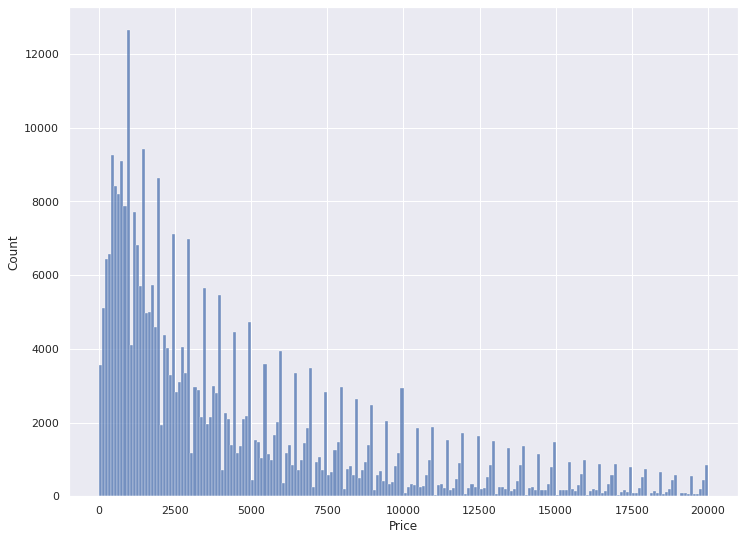

In [20]:
plt.figure(figsize = (12,9))
sns.histplot(data=df,x='Price',binwidth=100);

Вывод: **`¯\_(ツ)_/¯`**

Посмотрим числовое описание признака.

In [21]:
describe(df['Price'])

,Price
count,343593.00
mean,4555.15
mode,500.00
var,20385913.09
stddev,4515.08
min,1.00
25%,1200.00
50%,2890.00
75%,6500.00
max,20000.00


Видим 3 вещи:
* Мода == 500
* Минимальное значение == 1
* Левая граница выбросов == -6750

Судя по минимальному значению, есть некорректные цены типа 1,2,3 и т.д., которые надо отфильтровать.

Еще видим моду = 500. 

Посмотрим еще раз подсчет уникальных значений.

In [22]:
value_counts_(df['Price']).iloc[:10]

,count,frac
500,5670,0.02
1500,5394,0.02
1000,4648,0.01
1200,4594,0.01
2500,4438,0.01
600,3819,0.01
3500,3792,0.01
800,3784,0.01
2000,3431,0.01
999,3364,0.01


Кажется, что цена в 500 евро вполне себе допустимое значение.

Теперь посмотрим первые 150 уникальных значений этого признака, чтобы постараться определить левую границу выбросов, т.е. от минимальную стоимость автомобиля.

In [23]:
# df.query('Price < 500')
df['Price'].sort_values().unique()[:150]
# value_counts_('Price').sort_index().iloc[:100]

array([  1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  24,  25,  26,  27,  29,  30,
        32,  33,  35,  38,  39,  40,  45,  47,  49,  50,  55,  58,  59,
        60,  65,  66,  69,  70,  74,  75,  77,  79,  80,  85,  88,  89,
        90,  95,  98,  99, 100, 101, 105, 106, 108, 110, 111, 112, 115,
       117, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 132,
       133, 135, 139, 140, 142, 145, 149, 150, 155, 156, 157, 158, 159,
       160, 162, 165, 166, 169, 170, 173, 175, 177, 179, 180, 181, 185,
       188, 189, 190, 192, 193, 195, 196, 198, 199, 200, 202, 205, 209,
       210, 211, 215, 217, 219, 220, 222, 224, 225, 229, 230, 233, 235,
       236, 238, 240, 243, 245, 248, 249, 250, 251, 252, 253, 255, 259,
       260, 261, 263, 265, 266, 269, 270])

Какую ставить минимальную цену? 100 евро, 200?

Посмотрим на автомобили с ценой в 100 евро.

In [24]:
df[df['Price'] == 100].describe(datetime_is_numeric=True)[['RegistrationYear','Power','Kilometer','NumberOfPictures']]

,RegistrationYear,Power,Kilometer,NumberOfPictures
count,1031.00,1031.00,1031.00,1031.00
mean,1996.87,48.98,127555.77,0.00
min,1234.00,0.00,5000.00,0.00
25%,1995.00,0.00,125000.00,0.00
50%,1997.00,50.00,150000.00,0.00
75%,2000.00,75.00,150000.00,0.00
max,2222.00,3750.00,150000.00,0.00
std,37.97,127.64,46056.01,0.00


Нет какой-то характерной закономерности в автомобилях с этой ценой.

Возможно, они битые?

Посмотрим, были ли они в ремонте.

In [25]:
value_counts_(df.loc[df['Price'] == 100,'NotRepaired'])

,count,frac
NaN,490,0.48
yes,399,0.39
no,142,0.14


Почти 50% пропусков и только 14% были в ремонте - это мало что нам дает.

В итоге обрезаем цену **100 евро**, а все аномальные значения признаков обработаем отдельно.

In [26]:
print('Before:',df.count()[0])
df = df.drop(index=df[df['Price'] < 100].index)
print('After:',df.count()[0])

Before: 343593
After: 341051


**DateCrawled**

Этот признак нам не нужен для предсказания. Но понадобится только дни начала и окончания.

In [27]:
crawl_start_date = df['DateCrawled'].min()
crawl_end_date = df['DateCrawled'].max()
crawl_start_date,crawl_end_date

(Timestamp('2016-03-05 14:06:22'), Timestamp('2016-04-07 14:36:58'))

Обратим внимание, что сбор данных происходил исключительно в 2016 году.

In [28]:
df = df.drop(columns=['DateCrawled'])
df.head(1)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57


**VehicleType**

In [29]:
df['VehicleType'].dtype

dtype('O')

In [30]:
value_counts_(df['VehicleType'])

,count,frac
sedan,89087,0.26
small,77443,0.23
wagon,63464,0.19
NaN,32612,0.10
bus,28265,0.08
convertible,19817,0.06
coupe,15553,0.05
suv,11762,0.03
other,3048,0.01


Много пропусков.

In [31]:
print('Кол-во пропусков:',df['VehicleType'].isna().sum())

Кол-во пропусков: 32612


Простой способ: заменить на unknown.  
Точный способ: вменить по группировке, т.е. опереться на предположение, что автомобили одной марки, модели и года выпуска имеют один тип кузова.

In [32]:
# Проверим, есть ли в такой группировке
# Кол-во уникальных значений больше 1, т.е.
# Фактический тип кузова и np.nan
for name,data in df.groupby(['Brand','Model','RegistrationYear']):
    if data['VehicleType'].nunique() > 1 and pd.Series(data['VehicleType'].unique()).isna().sum() > 0:
        display(name)
        display(data)
        display(data['VehicleType'].unique())
        break


('alfa_romeo', '145', 2000)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
68907,2200,small,2000,manual,103,145,90000,12,petrol,alfa_romeo,no,2016-04-03,0,86368,2016-04-03 15:48:43
76056,150,small,2000,manual,102,145,150000,5,petrol,alfa_romeo,NaN,2016-03-08,0,92271,2016-03-09 16:47:58
83966,2200,small,2000,manual,103,145,90000,12,petrol,alfa_romeo,no,2016-04-03,0,86368,2016-04-03 15:54:45
105369,880,sedan,2000,manual,103,145,150000,9,petrol,alfa_romeo,no,2016-04-01,0,95666,2016-04-01 13:49:21
163242,300,NaN,2000,NaN,0,145,150000,0,NaN,alfa_romeo,NaN,2016-03-23,0,45881,2016-04-05 20:47:06
253005,2700,sedan,2000,manual,103,145,150000,3,petrol,alfa_romeo,no,2016-03-25,0,71638,2016-04-06 16:16:47
264969,700,small,2000,manual,120,145,150000,12,petrol,alfa_romeo,yes,2016-03-26,0,29584,2016-04-05 22:16:07
269933,300,NaN,2000,manual,90,145,150000,6,NaN,alfa_romeo,yes,2016-03-19,0,41812,2016-04-06 22:15:56
276316,500,NaN,2000,NaN,0,145,150000,12,NaN,alfa_romeo,NaN,2016-03-05,0,83139,2016-03-06 04:45:48
339029,5000,sedan,2000,manual,120,145,150000,1,petrol,alfa_romeo,no,2016-03-14,0,22177,2016-04-05 12:47:43


array(['small', 'sedan', nan], dtype=object)

Видим, что предположение не подтвердилось. Альфа Ромео 145 2000 года регистрации может быть и в `'small'` и `'sedan'` кузове.  
Значит не можем заполнить пропуски по бренду,модели и году выпуска.

Более того, судя по <a href='https://ru.wikipedia.org/wiki/Alfa_Romeo_145'>википедии</a>, Alfa Romeo 145 выпускался в 2х типах кузова: 3-х дв. хетчбек и 5 дв. хетчбек. 

* Является ли `'small'` соответствием 3-х. дв. хетчбеку, а `'sedan'` - 5 дв. или это ложные данные?

И является ли признак `'RegistrationYear'` годом выпуска? Год регистрации и год выпуска одно ли это и то же?

Заменим пропуски на `'unknown'`

In [33]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Молодец, что используешь заглушку типа `unknown` и заполняешь ими пропуски.

In [34]:
value_counts_(df['VehicleType'])

,count,frac
sedan,89087,0.26
small,77443,0.23
wagon,63464,0.19
unknown,32612,0.10
bus,28265,0.08
convertible,19817,0.06
coupe,15553,0.05
suv,11762,0.03
other,3048,0.01


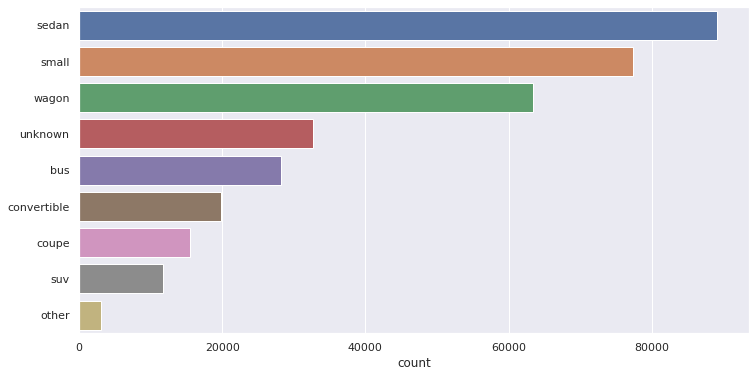

In [35]:
temp = value_counts_(df['VehicleType'])
plt.figure(figsize=(12,6))
sns.barplot(y=temp.index,x='count',data=temp)
del temp

**RegistrationYear**

In [36]:
df['RegistrationYear'].dtype

dtype('int64')

In [37]:
df['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222,
       2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500,
       4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 7000, 7100, 7800,
       8200, 8500, 8888, 9000, 9450, 9999])

* Видим определенно мусорные значения до 1800 года и после 2066.  

Посчитаем их.


In [38]:
df.query('(RegistrationYear <= 1800) or (RegistrationYear > 2019)')['Price'].count()

115

Их мало, удалим.

In [39]:
print('Before:',df.count()[0])
df = df.drop(index=df.query('(RegistrationYear <= 1800) or (RegistrationYear > 2019)').index)
print('After:',df.count()[0])

Before: 341051
After: 340936


In [40]:
with pd.option_context("display.max_rows", 200):
    display(value_counts_(df['RegistrationYear']).sort_index())

,count,frac
1910,34,0.00
1923,2,0.00
1925,1,0.00
1927,1,0.00
1928,2,0.00
1929,6,0.00
1930,2,0.00
1931,1,0.00
1932,3,0.00
1933,2,0.00


Построим гистограмму.

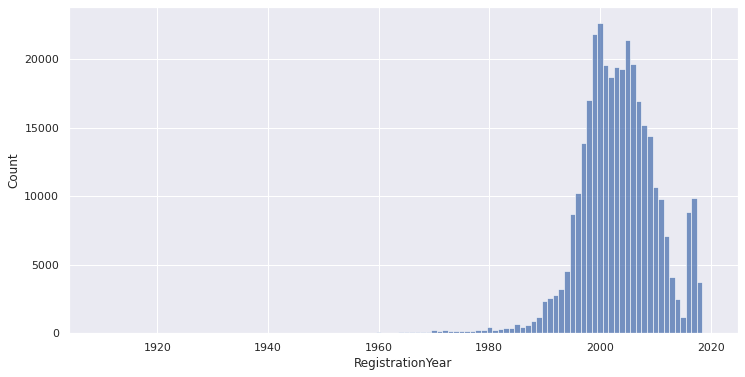

In [41]:
plt.figure(figsize=(12,6))
sns.histplot(data=df,x='RegistrationYear',discrete=True);

Построим ящик с усами для оценки выбросов.

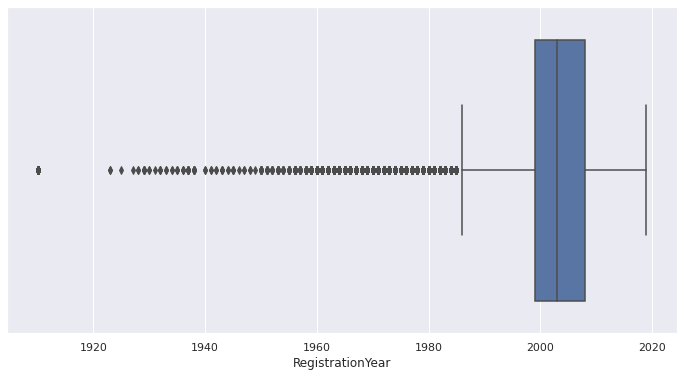

In [42]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df,x='RegistrationYear');

In [43]:
describe(df['RegistrationYear'])

,RegistrationYear
count,340936.00
mean,2003.21
mode,2000.00
var,53.42
stddev,7.31
min,1910.00
25%,1999.00
50%,2003.00
75%,2008.00
max,2019.00


Видим, что:
* по 1,5 интерквартильному размаху выбросы левее 1985 года. 
* есть раритетные модели, т.е. дорогие и до 1985 года выпуска.
* есть автомобили с годом выпуска находящимся в будущем по сравнению с датой сбора

In [44]:
print('Год сбора данных:', crawl_start_date.year)

Год сбора данных: 2016


Какие года стоит использовать в обучении модели?

Посмотрим на автомобили страше 2016 года, чтобы решить использовать их или нет.

In [45]:
df[df['RegistrationYear'] > 2016]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2900,unknown,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
26,5555,unknown,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
48,7750,unknown,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,0,48499,2016-03-31 21:47:44
51,2000,unknown,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08
57,2399,unknown,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,3600,unknown,2017,manual,86,transit,150000,5,gasoline,ford,NaN,2016-03-11,0,32339,2016-03-12 05:45:02
354140,1000,unknown,2017,manual,101,a4,150000,9,NaN,audi,NaN,2016-03-29,0,38315,2016-04-06 02:44:27
354203,2140,unknown,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17,0,44866,2016-03-29 15:45:04
354253,1250,unknown,2018,NaN,0,corsa,150000,0,petrol,opel,NaN,2016-03-25,0,45527,2016-04-06 07:46:13


In [46]:
df[df['RegistrationYear'] > 2016].describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,13615.00,13615.00,13615.00,13615.00,13615.00,13615.00,13615.00
mean,3341.39,2017.28,88.84,132840.98,4.84,0.00,48535.71
std,3460.93,0.45,249.26,35132.35,3.99,0.00,25103.95
min,100.00,2017.00,0.00,5000.00,0.00,0.00,1067.00
25%,1100.00,2017.00,39.00,125000.00,1.00,0.00,28218.00
50%,2000.00,2017.00,80.00,150000.00,4.00,0.00,46535.00
75%,4250.00,2018.00,117.00,150000.00,8.00,0.00,66498.50
max,20000.00,2019.00,16011.00,150000.00,12.00,0.00,99994.00


Видим, что в большинстве это уже автомобили с километражем, т.е. не новые или не готовящиеся к выпуску.

Здесь есть три подхода:
* признать, что данные синтетические и дата сбора сгенерирована, 
* представить, что это ошибка, т.е. данных из будущего быть не может,
* использовать данные после даты сбора как тестовые,
* игнорировать это несоответствие.

**Определим, что автомобили с годом выпуска находящимся после даты сбора данных являются выбросами.**  
Вместе с этим можем использовать их для теста итоговой модели.

In [47]:
crawl_end_date

Timestamp('2016-04-07 14:36:58')

Определим границу выбросов по дате регистрации и месяцу регистрации в 2016-04.

In [48]:
df['RegistrationMonth'].value_counts()

3     33690
0     31542
6     30717
4     28572
5     28395
7     26568
10    25540
11    23690
12    23669
9     23292
1     22490
8     22050
2     20721
Name: RegistrationMonth, dtype: int64

In [49]:
df['RegistrationMonth'].nunique()

13

В месяце регистрации 13 уникальных значений и есть 0.  

In [50]:
df.loc[(df['RegistrationMonth'] == 0)&(df['RegistrationYear'] == 2016)].describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,2429.00,2429.00,2429.00,2429.00,2429.00,2429.00,2429.00
mean,1503.50,2016.00,68.35,136574.72,0.00,0.00,48673.02
std,2161.14,0.00,333.70,34086.71,0.00,0.00,25601.40
min,100.00,2016.00,0.00,5000.00,0.00,0.00,1127.00
25%,400.00,2016.00,0.00,150000.00,0.00,0.00,27383.00
50%,750.00,2016.00,60.00,150000.00,0.00,0.00,46509.00
75%,1600.00,2016.00,100.00,150000.00,0.00,0.00,66802.00
max,20000.00,2016.00,12510.00,150000.00,0.00,0.00,99998.00


Если мы отрезаем значения по дате сбора данных, то в момент этого сбора не может быть автомобилей того же года выпуска, но уже с неправдоподобно большим километражем.

Как определить правдоподобный километраж?

Если автомобиль 2016 года выпуска, то чем ближе его месяц регистрации к месяцу сбора данных, тем меньше должен быть километраж.  
Посмотрим распределение километража в автомобилях 2016 года с месяцем от 0 по 4 включительно.

In [51]:
df.loc[(df['RegistrationMonth'] < 5)&(df['RegistrationYear'] == 2016)].describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,4431.00,4431.00,4431.00,4431.00,4431.00,4431.00,4431.00
mean,2050.03,2016.00,73.61,132989.17,1.24,0.00,48126.00
std,3121.78,0.00,259.29,39215.45,1.55,0.00,25333.44
min,100.00,2016.00,0.00,5000.00,0.00,0.00,1067.00
25%,450.00,2016.00,0.00,150000.00,0.00,0.00,27619.00
50%,900.00,2016.00,70.00,150000.00,0.00,0.00,46236.00
75%,2100.00,2016.00,101.00,150000.00,3.00,0.00,66539.50
max,20000.00,2016.00,12510.00,150000.00,4.00,0.00,99998.00


In [52]:
temp_data = value_counts_(df.loc[(df['RegistrationMonth'] < 5)&(df['RegistrationYear'] == 2016),'Kilometer'])
temp_data

,count,frac
150000,3440,0.78
125000,335,0.08
5000,252,0.06
100000,122,0.03
90000,82,0.02
80000,44,0.01
60000,33,0.01
20000,33,0.01
70000,30,0.01
40000,20,0.00


Выглядит неправдоподобно.

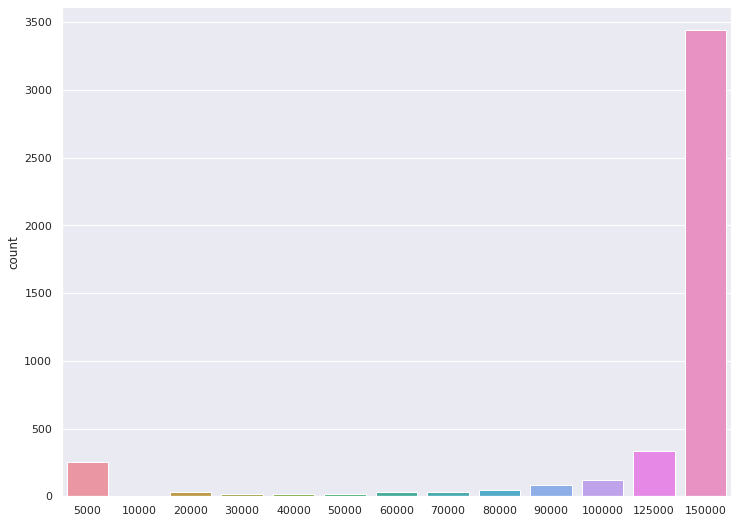

In [53]:
plt.figure(figsize=(12,9))
sns.barplot(data=temp_data,
            x=temp_data.index,
            y=temp_data['count']);

Предположим автомобиль был выпущен строго в новый 2016 год. На момент сбора данных отъедил 4 месяца.  
В месяце пусть будет 30 дней.
Получается в день такой автомобиль проезжал:

In [54]:
temp_data2 = pd.DataFrame(columns=['4months','1day'])
for km in temp_data.index.sort_values():
#     print(f'Километраж за 4 месяца: {km}. В день: {km/4/30:.0f} км.')
    result = pd.DataFrame({'4months':km,'1day':km/4/30},index=[0])
#     display(result)
    temp_data2 = pd.concat([temp_data2,result],axis=0).reset_index(drop=True)
    
# print('Километраж')
temp_data2

,4months,1day
0,5000,41.67
1,10000,83.33
2,20000,166.67
3,30000,250.00
4,40000,333.33
5,50000,416.67
6,60000,500.00
7,70000,583.33
8,80000,666.67
9,90000,750.00


83 и 166 км. звучит как относительно разумный дневной километраж для неводящего человека (меня).

Поэтому автомобили 2016 года регистрации и месяцем регистрации равным 0 будем отсекать по километражу (20000).

У нас здесь 2 задачи:
* Убрать автомобили:
    * Старше апреля 2016 (2016-04)
    * Автомобили 2016 года, у которых `'RegistrationMonth'` == `0` и `'Kilometers'` <= `20000`
* Эти убранные объявления сохранить в отдельном датафрейме

Выполним задачу в обратном порядке. Сначала сохраним отфильтрованные значения в отдельный датафрейм.

In [55]:
def year_outliers(df):
    mask_1 = (df['RegistrationYear'] >= 2016)&(df['RegistrationMonth'] > 4)
    df_reg_year_outliers_1 = df.loc[mask_1]
    
    mask_2 = (df['RegistrationYear'] == 2016)&\
             (df['RegistrationMonth'] == 0)&\
             (df['Kilometer'] <= 20000)
    
    df_reg_year_outliers_2 = df.loc[mask_2]
    
    result = pd.concat([df_reg_year_outliers_1,df_reg_year_outliers_2])
    return result

df_reg_year_outliers = year_outliers(df)


In [56]:
# df_reg_year_outliers.info()
df_reg_year_outliers.head(2)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2900,unknown,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
31,899,unknown,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,0,37075,2016-03-29 17:43:07


Удалим получившиеся строки из основного датафрейма.

In [57]:
print('Before:',df.count()[0])
df = df.drop(index=df_reg_year_outliers.index)
print('After:',df.count()[0])

Before: 340936
After: 329626


Автомобили 2016 года, у которых явно указан месяц, но с километражем большим 20000 оставим, аргументируя игрущечностью данных. В рабочих условиях нужно выяснить как были получены эти данные, т.к. здесь налицо ошибка.

Теперь найдем левую границу выбросов после изменений.

In [58]:
describe(df['RegistrationYear'])

,RegistrationYear
count,329626.00
mean,2002.74
mode,2000.00
var,48.72
stddev,6.98
min,1910.00
25%,1999.00
50%,2003.00
75%,2007.00
max,2019.00


* Видим левую границу выбросов: `1987`

Посмотрим на выбросы с помощью ящика с усами.

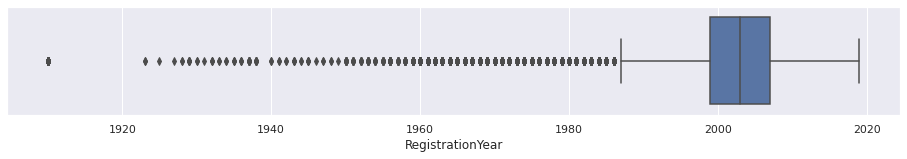

In [59]:
plt.figure(figsize=(16,2))
sns.boxplot(data=df,x='RegistrationYear');

Вынесем в отдельный датафрейм автомобили старше 1987 года и удалим из обучающего.

In [60]:
df_older_1987 = df.loc[df['RegistrationYear'] < 1987]

In [61]:
print('Before:',df.count()[0])
df = df.drop(index=df_older_1987.index)
print('After:',df.count()[0])

Before: 329626
After: 323676


**Gearbox**

In [62]:
df['Gearbox'].dtype

dtype('O')

In [63]:
value_counts_(df['Gearbox'])

,count,frac
manual,247505,0.76
auto,61828,0.19
NaN,14343,0.04


Заменим пропуски на 'unknown'

In [64]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')

In [65]:
value_counts_(df['Gearbox'])

,count,frac
manual,247505,0.76
auto,61828,0.19
unknown,14343,0.04


**Power**

In [66]:
df['Power'].dtype

dtype('int64')

In [67]:
value_counts_(df['Power'])

,count,frac
0,31011,0.10
75,21990,0.07
60,14578,0.05
150,13703,0.04
101,12423,0.04
...,...,...
953,1,0.00
1105,1,0.00
442,1,0.00
337,1,0.00


In [68]:
df['Power'].isna().sum()

0

In [69]:
df['Power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

Здесь много мусорных значений. Попробуем определить границу возможной мощности.

In [70]:
value_counts_(df['Power']).sort_index(ascending=False).loc[1100:1000]

,count,frac
1100,1,0.00
1090,1,0.00
1082,1,0.00
1079,1,0.00
1062,1,0.00
1056,1,0.00
1055,1,0.00
1054,1,0.00
1024,1,0.00
1021,2,0.00


In [71]:
df[df['Power']==1001]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
5328,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN,2016-03-29,0,33154,2016-04-06 05:44:36
49724,1500,wagon,2003,manual,1001,focus,150000,10,gasoline,ford,NaN,2016-03-05,0,32791,2016-03-12 05:18:00
79305,1650,small,2000,auto,1001,a_klasse,150000,3,petrol,mercedes_benz,no,2016-03-29,0,89134,2016-04-04 01:18:34
179821,1100,sedan,1995,manual,1001,a4,150000,2,NaN,audi,no,2016-04-04,0,16259,2016-04-06 18:18:45
307044,1500,sedan,1999,manual,1001,astra,125000,6,petrol,opel,no,2016-03-27,0,72108,2016-04-02 03:46:52
351947,1500,bus,2001,manual,1001,zafira,5000,7,gasoline,opel,no,2016-03-07,0,66117,2016-03-09 12:47:08


Весьма сомнительно, что, например, фокус 2003 года без информации о ремонте имеет мощность 1001. Это все еще похоже на неверные значения.

In [72]:
# print('Before:',df.count()[0])
# df = df.drop(index=df[df['Power'] > 1000].index)
# print('After:',df.count()[0])

Посмотрим общую гистограмму мощности.

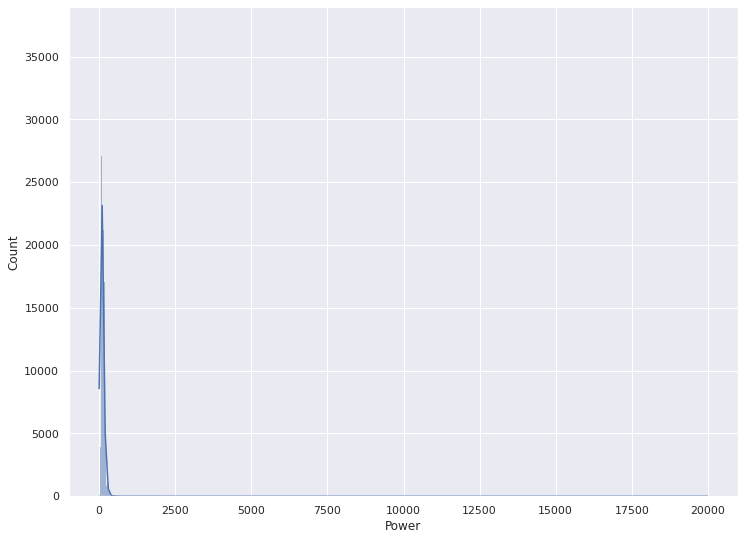

In [73]:
plt.figure(figsize=(12,9))
# plt.xlim(-10,400)
sns.histplot(data=df,x='Power',kde=True,binwidth=10);

Посмотрим гистограмму мощности до 400 ед.

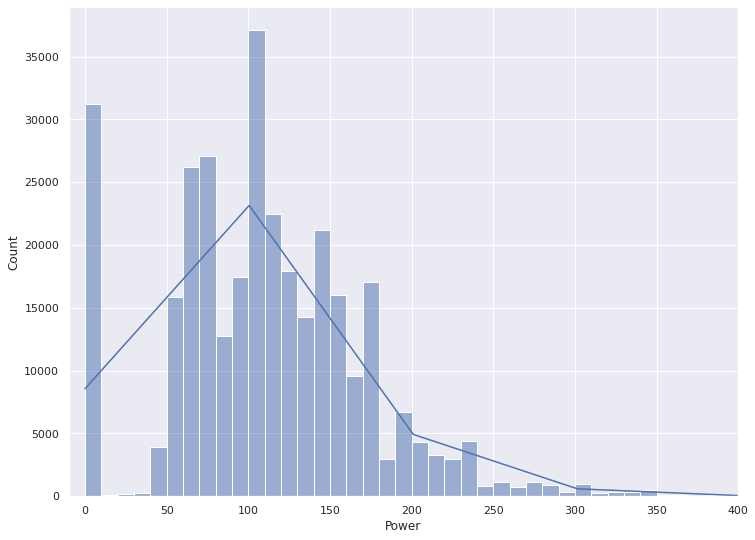

In [74]:
plt.figure(figsize=(12,9))
plt.xlim(-10,400)
sns.histplot(data=df,x='Power',kde=True,binwidth=10);

Построим ящик с усами для оценки выбросов.

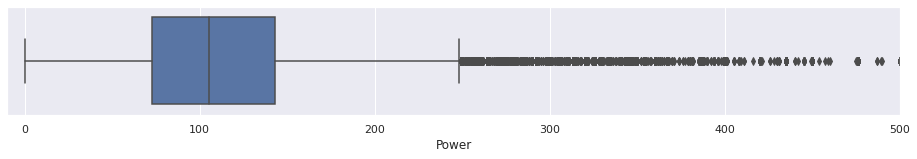

In [75]:
plt.figure(figsize=(16,2))
plt.xlim(-10,500)
sns.boxplot(data=df,x='Power');

In [76]:
describe(df['Power'])

,Power
count,323676.00
mean,112.65
mode,0.00
var,34173.63
stddev,184.86
min,0.00
25%,73.00
50%,105.00
75%,143.00
max,20000.00


`outlier_border_left` и `outlier_border_right` - это границы выбросов рассчитаные по 1,5 IQR от 1 и 3 квартиля.

```python
#     Левая граница ящика с усами
    outlier_border_left = quartile_1 - 1.5 * iqr
#     Правая граница ящика с усами
    outlier_border_right = quartile_3 + 1.5 * iqr
```

* Мощность 0 быть не может
* Правая граница выбросов 248
* Нужно определить левую границу, т.е. какое реальное минимальное кол-во "мощности" может быть

Удалим значения с 0.

In [77]:
print('Before:',df.count()[0])
df = df.drop(index=df[df['Power'] == 0].index)
print('After:',df.count()[0])

Before: 323676
After: 292665


В качестве правой границы выбросов будем использовать 400 ед. Предполагая, что это более реалистичный верхний порог мощности.

Удалим значения больше 400, предварительно сохранив их в отдельных датафрейм для оценки эффективности модели на автомобилях с мощностью больше 400.

In [78]:
df_400 = df.loc[df['Power'] >= 400].copy()

In [79]:
print('Before:',df.count()[0])
df = df.drop(index=df[df['Power'] >= 400].index)
print('After:',df.count()[0])

Before: 292665
After: 291973


Определим левую границу в 50 единиц. Опираясь на предположение, что автомобилей с мощностью меньше 50 не бывает (?).
Удалим все, что меньше. И сохраним эти автомобили для тех же целей.

In [80]:
df_50 = df.loc[df['Power'] < 50].copy()

In [81]:
print('Before:',df.count()[0])
df = df.drop(index=df[df['Power'] < 50].index)
print('After:',df.count()[0])

Before: 291973
After: 287355


**Model**

In [82]:
df['Model'].dtype

dtype('O')

In [83]:
value_counts_(df['Model'])

,count,frac
golf,24502,0.09
other,18173,0.06
3er,17277,0.06
NaN,10143,0.04
polo,9773,0.03
...,...,...
i3,5,0.00
kalina,5,0.00
samara,5,0.00
rangerover,3,0.00


In [84]:
df['Model'].isna().sum()

10143

In [85]:
df['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000',
       '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse',
       'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok',
       'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo',
       'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster',
       'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max',
       'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival',
       'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic',
       'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper',
       'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire',
       'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo',
       'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort',
       'espace', 'ex

Похоже, что здесь есть ошибки.  
Напр.: 
* `'3er'` может быть равно `'3_reihe'`
* `'range_rover'` и `'rangerover'`



In [86]:
df.loc[df['Model']=='3er','Brand'].value_counts()

bmw    17277
Name: Brand, dtype: int64

In [87]:
df.loc[df['Model']=='3_reihe','Brand'].value_counts()

peugeot    1884
mazda      1097
Name: Brand, dtype: int64

In [88]:
df.loc[df['Model']=='range_rover','Brand'].value_counts()

land_rover    66
Name: Brand, dtype: int64

In [89]:
df.loc[df['Model']=='rangerover','Brand'].value_counts()

rover    3
Name: Brand, dtype: int64

Нет, похоже, что это разные модели разных производителей.

Заполним пропуски `'unknown'`

In [90]:
df['Model'] = df['Model'].fillna('unknown')

In [91]:
df['Model'].isna().sum()

0

**Kilometer**

In [92]:
df['Kilometer'].dtype

dtype('int64')

In [93]:
value_counts_(df['Kilometer'])

,count,frac
150000,191759,0.67
125000,30877,0.11
100000,12211,0.04
90000,9938,0.03
80000,8672,0.03
70000,7505,0.03
60000,6568,0.02
50000,5462,0.02
40000,4335,0.02
30000,3720,0.01


Отметим, что это категориальный признак.

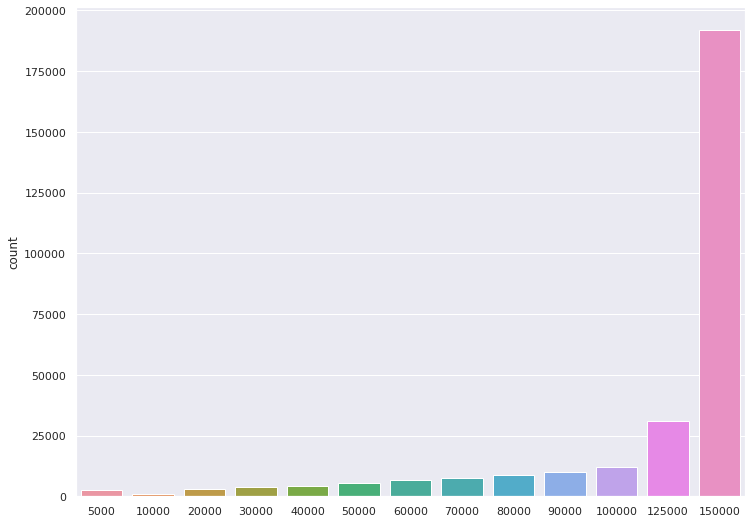

In [94]:
plt.figure(figsize=(12,9))
sns.barplot(data=value_counts_(df['Kilometer']),
            x=value_counts_(df['Kilometer']).index,
            y=value_counts_(df['Kilometer'])['count']);

**RegistrationMonth**

In [95]:
df['RegistrationMonth'].dtype

dtype('int64')

In [96]:
value_counts_(df['RegistrationMonth']).sort_index()

,count,frac
0,18567,0.06
1,19951,0.07
2,18748,0.07
3,30335,0.11
4,25711,0.09
5,24305,0.08
6,26115,0.09
7,22420,0.08
8,18820,0.07
9,19992,0.07


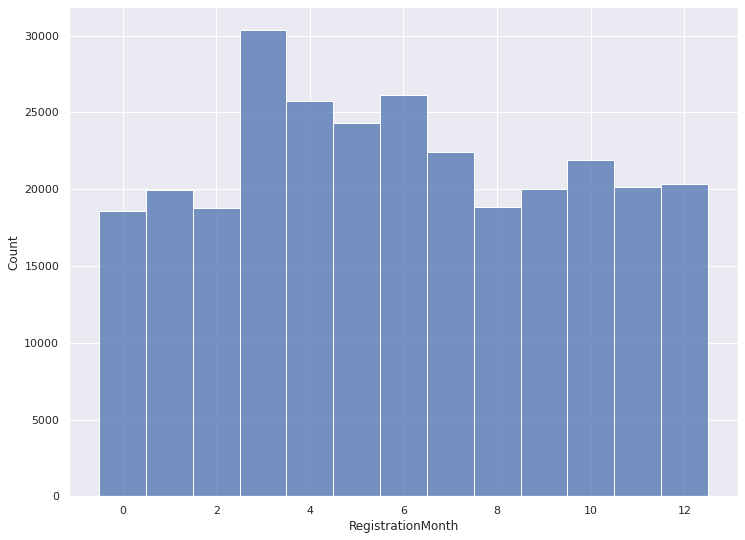

In [97]:
sns.histplot(data=df,x='RegistrationMonth',discrete=True);

Предполагаю, что месяц регистрации автомобиля не влияет на его стоимость. Чтобы это проверить построим ящик с усами стоимости с разделением по месяцам. Другими словами попытаемся выяснить имеет ли он какую-то предсказательную силу или нет.

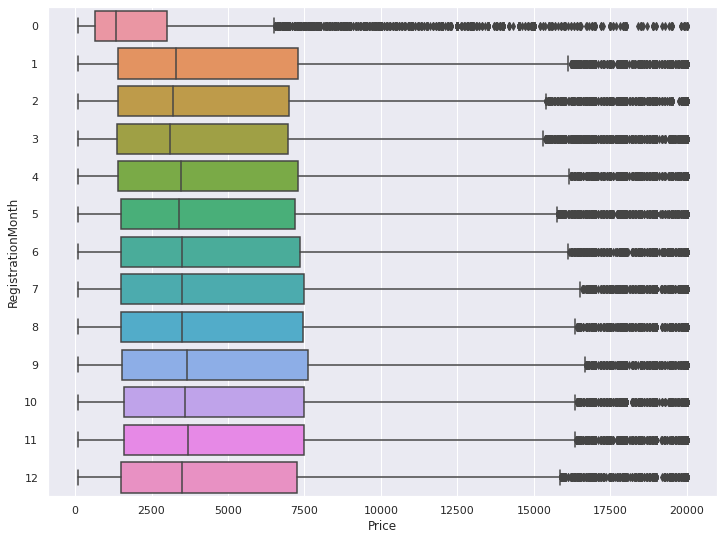

In [98]:
sns.boxplot(data=df,x='Price',y='RegistrationMonth',orient='h');

Распределение всех месяцев, кроме 0 похожи.  
То, что у 0 распределение отличается при примерно схожем кол-ве значений, скорее всего о чем-то говорить, но сложно предположить о чем.

В целом выглядит, что месяц не влияет на стоимость. Но, чтобы выяснить природу распределения 0 месяца, нужно исследовать способ сбора данных. Поэтому сейчас принимаем решение о неиспользовании этого признака при обучении модели.

In [99]:
df = df.drop(columns=['RegistrationMonth'])
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'DateCreated',
       'NumberOfPictures', 'PostalCode', 'LastSeen'],
      dtype='object')

**FuelType**

In [100]:
df['FuelType'].dtype

dtype('O')

In [101]:
value_counts_(df['FuelType'])

,count,frac
petrol,180250,0.63
gasoline,86872,0.30
NaN,14834,0.05
lpg,4635,0.02
cng,481,0.00
hybrid,199,0.00
other,52,0.00
electric,32,0.00


In [102]:
df['FuelType'] = df['FuelType'].fillna('unknown')

In [103]:
value_counts_(df['FuelType'])

,count,frac
petrol,180250,0.63
gasoline,86872,0.30
unknown,14834,0.05
lpg,4635,0.02
cng,481,0.00
hybrid,199,0.00
other,52,0.00
electric,32,0.00


`'petrol'` и `'gasoline'` это одно и тоже?

Назовем все `'petrol'`

In [104]:
df.loc[df['FuelType'] == 'gasoline','FuelType'] = 'petrol'

In [105]:
value_counts_(df['FuelType'])

,count,frac
petrol,267122,0.93
unknown,14834,0.05
lpg,4635,0.02
cng,481,0.00
hybrid,199,0.00
other,52,0.00
electric,32,0.00


**Brand**

In [106]:
df['Brand'].dtype

dtype('O')

In [107]:
value_counts_(df["Brand"])

,count,frac
volkswagen,62313,0.22
bmw,31994,0.11
opel,30873,0.11
mercedes_benz,26432,0.09
audi,25370,0.09
ford,20208,0.07
renault,13743,0.05
peugeot,9150,0.03
fiat,7258,0.03
seat,5833,0.02


In [108]:
df['Brand'].isna().sum()

0

**NotRepaired**

In [109]:
df['NotRepaired'].dtype

dtype('O')

In [110]:
value_counts_(df['NotRepaired'])

,count,frac
no,218814,0.76
NaN,41119,0.14
yes,27422,0.10


In [111]:
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

**DateCreated**

In [112]:
df['DateCreated'].dtype

dtype('<M8[ns]')

In [113]:
value_counts_(df['DateCreated'])

,count,frac
2016-04-03,11347,0.04
2016-04-04,10885,0.04
2016-03-12,10591,0.04
2016-03-20,10523,0.04
2016-03-21,10184,0.04
...,...,...
2016-01-15,1,0.00
2016-01-18,1,0.00
2016-01-16,1,0.00
2015-08-10,1,0.00


In [114]:
df['DateCreated'].describe(datetime_is_numeric=True)

count                           287355
mean     2016-03-20 19:12:38.185519872
min                2015-03-20 00:00:00
25%                2016-03-13 00:00:00
50%                2016-03-21 00:00:00
75%                2016-03-29 00:00:00
max                2016-04-07 00:00:00
Name: DateCreated, dtype: object

Здесь снова видим, что дата создания объявления синтетическая, т.к. в них предлагаются автомобили из будущего.

Этот столбец нам не понадобится.

In [115]:
df = df.drop(columns=['DateCreated'])
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'NumberOfPictures',
       'PostalCode', 'LastSeen'],
      dtype='object')

**NumberOfPictures**

In [116]:
df['NumberOfPictures'].dtype

dtype('int64')

In [117]:
value_counts_(df['NumberOfPictures'])

,count,frac
0,287355,1.00


Здесь совершенно пусто - удалим столбец.

In [118]:
df = df.drop(columns=['NumberOfPictures'])
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode',
       'LastSeen'],
      dtype='object')

**PostalCode**

In [119]:
df['PostalCode'].dtype

dtype('int64')

In [120]:
value_counts_(df['PostalCode'])

,count,frac
10115,797,0.00
65428,513,0.00
66333,266,0.00
60311,259,0.00
52525,244,0.00
...,...,...
96196,1,0.00
18279,1,0.00
31717,1,0.00
16918,1,0.00


In [121]:
df['PostalCode'].sort_values().unique()[:50]

array([1067, 1068, 1069, 1097, 1099, 1108, 1109, 1127, 1129, 1139, 1156,
       1157, 1159, 1169, 1187, 1189, 1217, 1219, 1237, 1239, 1257, 1259,
       1277, 1279, 1307, 1309, 1324, 1326, 1328, 1445, 1454, 1458, 1465,
       1468, 1471, 1477, 1558, 1561, 1587, 1589, 1591, 1594, 1609, 1612,
       1616, 1619, 1623, 1640, 1662, 1665])

In [122]:
df['PostalCode'].sort_values().unique()[:-50:-1]

array([99998, 99996, 99994, 99991, 99988, 99986, 99976, 99974, 99958,
       99955, 99947, 99898, 99897, 99894, 99891, 99887, 99885, 99880,
       99869, 99867, 99848, 99846, 99842, 99837, 99834, 99831, 99830,
       99826, 99820, 99819, 99817, 99768, 99765, 99762, 99759, 99755,
       99752, 99735, 99734, 99718, 99713, 99706, 99638, 99636, 99634,
       99631, 99628, 99625, 99610])

Конечно, регион может влиять на стоимость автомобиля, но для этого категоризировать регионы в несколько десятков категорий, а не по почтовому индексу. Чтобы не получилось 100 тыс. столбцов в результате OHE.

Поэтому сейчас удалим этот признак.

In [123]:
df = df.drop(columns='PostalCode')
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'LastSeen'],
      dtype='object')

**LastSeen**

In [124]:
df['LastSeen'].dtype

dtype('<M8[ns]')

In [125]:
value_counts_(df["LastSeen"])

,count,frac
2016-04-07 09:44:27,16,0.00
2016-04-07 14:57:54,15,0.00
2016-04-06 12:44:51,15,0.00
2016-04-05 21:16:47,15,0.00
2016-04-06 13:46:17,15,0.00
...,...,...
2016-03-31 14:18:12,1,0.00
2016-03-10 11:18:09,1,0.00
2016-03-12 20:18:23,1,0.00
2016-03-26 04:47:14,1,0.00


In [126]:
df['LastSeen'].describe(datetime_is_numeric=True)

count                           287355
mean     2016-03-30 04:41:27.190941440
min                2016-03-05 14:15:08
25%         2016-03-23 13:16:19.500000
50%                2016-04-04 01:16:24
75%                2016-04-06 10:45:48
max                2016-04-07 14:58:51
Name: LastSeen, dtype: object

Этот столбец нам тоже не понадобится.

In [127]:
df = df.drop(columns=['LastSeen'])
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

### Корреляции и поиск зависимостей

In [128]:
df.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.00,0.59,0.51,-0.40
RegistrationYear,0.59,1.00,0.11,-0.40
Power,0.51,0.11,1.00,0.10
Kilometer,-0.40,-0.40,0.10,1.00


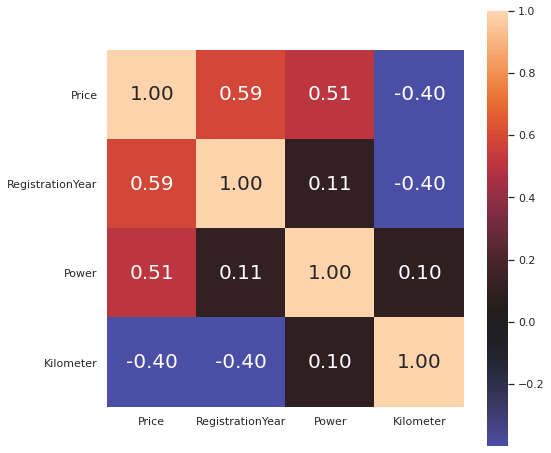

In [129]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),annot=True,center=0,square=True,fmt='.2f',annot_kws={"size": 20});

* Видим среднюю корреляцию стоимости с годом регистрации, мощностью и километражем.  
* Слабую корреляцию километража и года регистрации.

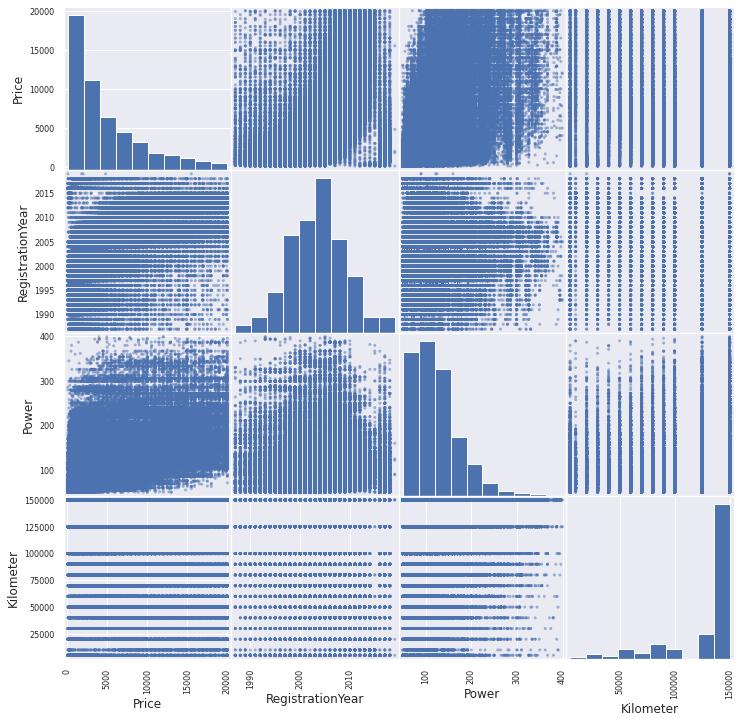

In [130]:
pd.plotting.scatter_matrix(df,figsize=(12,12));

Ничего необычного.

Исследуем стоимость с разделением по категориальным признакам.

**Тип кузова (`'VehicleType'`)** 

In [131]:
multiv_stats(df,'VehicleType')

,Price_mean,Price_median,Price_count,Price_frac
VehicleType,,,,
All,4891.84,3200,287355,1.00
sedan,4973.28,3250,80863,0.28
small,2990.56,1800,65695,0.23
wagon,5177.22,3500,58777,0.20
bus,5757.74,4500,25915,0.09
convertible,7011.53,5700,17979,0.06
coupe,6311.66,4200,13543,0.05
unknown,2864.60,1500,11735,0.04
suv,9388.05,8900,10627,0.04


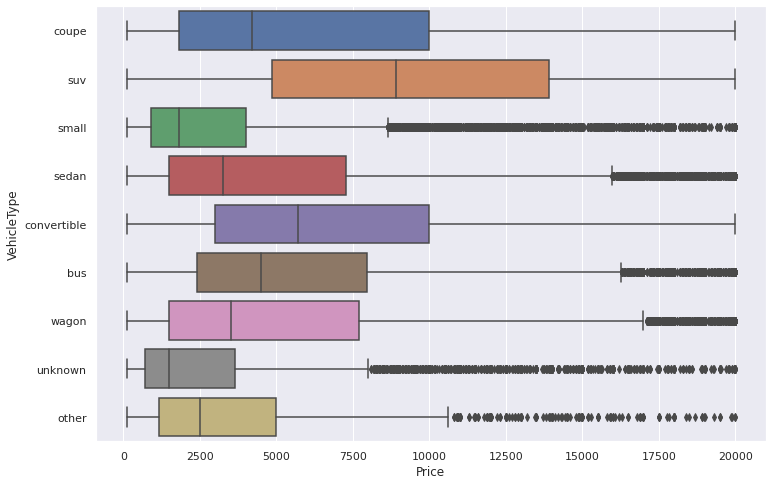

In [132]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df,x='Price',y='VehicleType');

* Распределение стоимости у разных кузовов разные.
* Распределение `'unknown'` напоминает `'small'`

**Тип коробки передач (`'Gearbox'`)** 

In [133]:
multiv_stats(df,'Gearbox')

,Price_mean,Price_median,Price_count,Price_frac
Gearbox,,,,
All,4891.84,3200,287355,1.00
manual,4333.56,2800,225525,0.78
auto,7268.80,5999,56842,0.20
unknown,3046.09,1800,4988,0.02


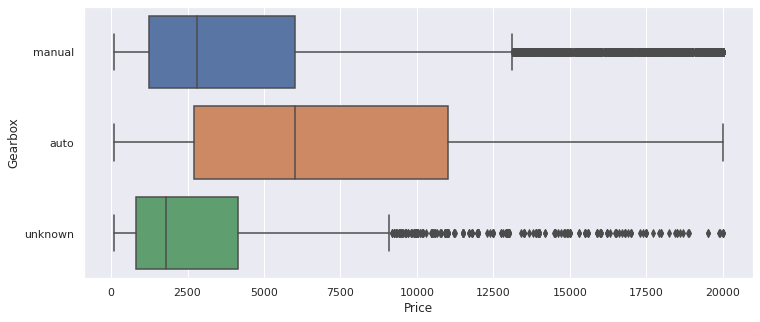

In [134]:
plt.figure(figsize=(12,5))
sns.boxplot(data=df,x='Price',y='Gearbox');

Посмотрим распределение этого категориального признака с учетом года производства.

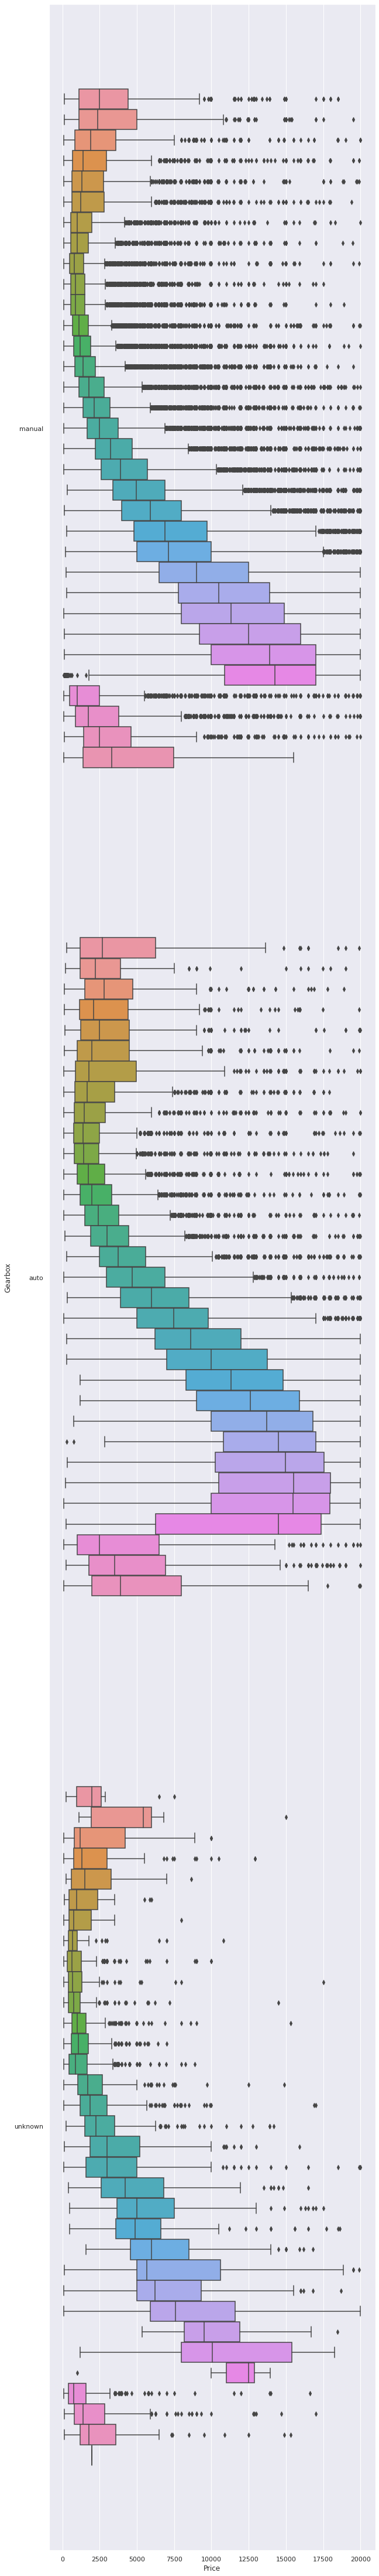

In [135]:
plt.figure(figsize = (10,80))
sns.boxplot(data=df,x='Price',y='Gearbox',hue='RegistrationYear')
plt.legend([],[], frameon=False)
plt.show()

Сильно ровная картинка. Отражает ли она действительность, либо это синтетические данные?

Посмотрим то же распределение, но с разбиением годов регистрации по бинам.

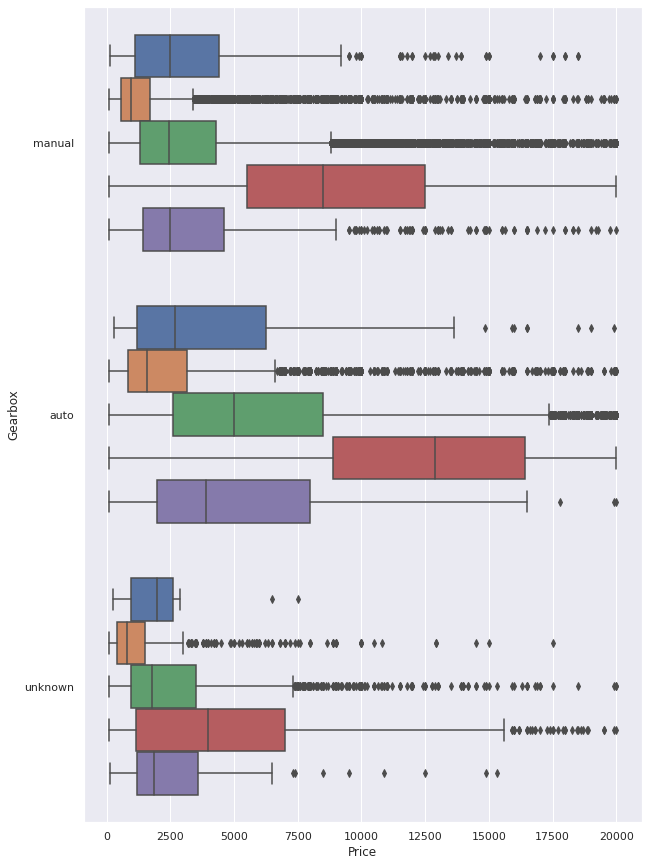

In [136]:
df_temp = df.copy()
start_year = df_temp['RegistrationYear'].min()
end_year = df_temp['RegistrationYear'].max()
# print(start_year,end_year)

test = np.arange(start_year,end_year+11,10)#.astype(int)
test = np.insert(test,0,0)
# test

df_temp['RegistrationYearBins'] = pd.cut(df_temp['RegistrationYear'],bins=test)

plt.figure(figsize = (10,15))
sns.boxplot(data=df_temp,x='Price',y='Gearbox',hue='RegistrationYearBins');
plt.legend([],[], frameon=False)
plt.show()
del df_temp

В целом можно сказать, что тип коробки передач влияет на стоимость в завиcимости от года регистрации.

**Модель (`'Model'`)** 

In [137]:
with pd.option_context("display.max_rows", 300):
    display(multiv_stats(df,'Model'))

,Price_mean,Price_median,Price_count,Price_frac
Model,,,,
All,4891.84,3200.00,287355,1.00
golf,4544.62,2750.00,24502,0.09
other,4579.30,2800.00,18173,0.06
3er,5379.54,3800.00,17277,0.06
unknown,3543.05,1900.00,10143,0.04
polo,3037.32,1850.00,9773,0.03
astra,3344.90,2000.00,9072,0.03
corsa,2340.85,1450.00,8913,0.03
a4,6191.45,4900.00,8788,0.03


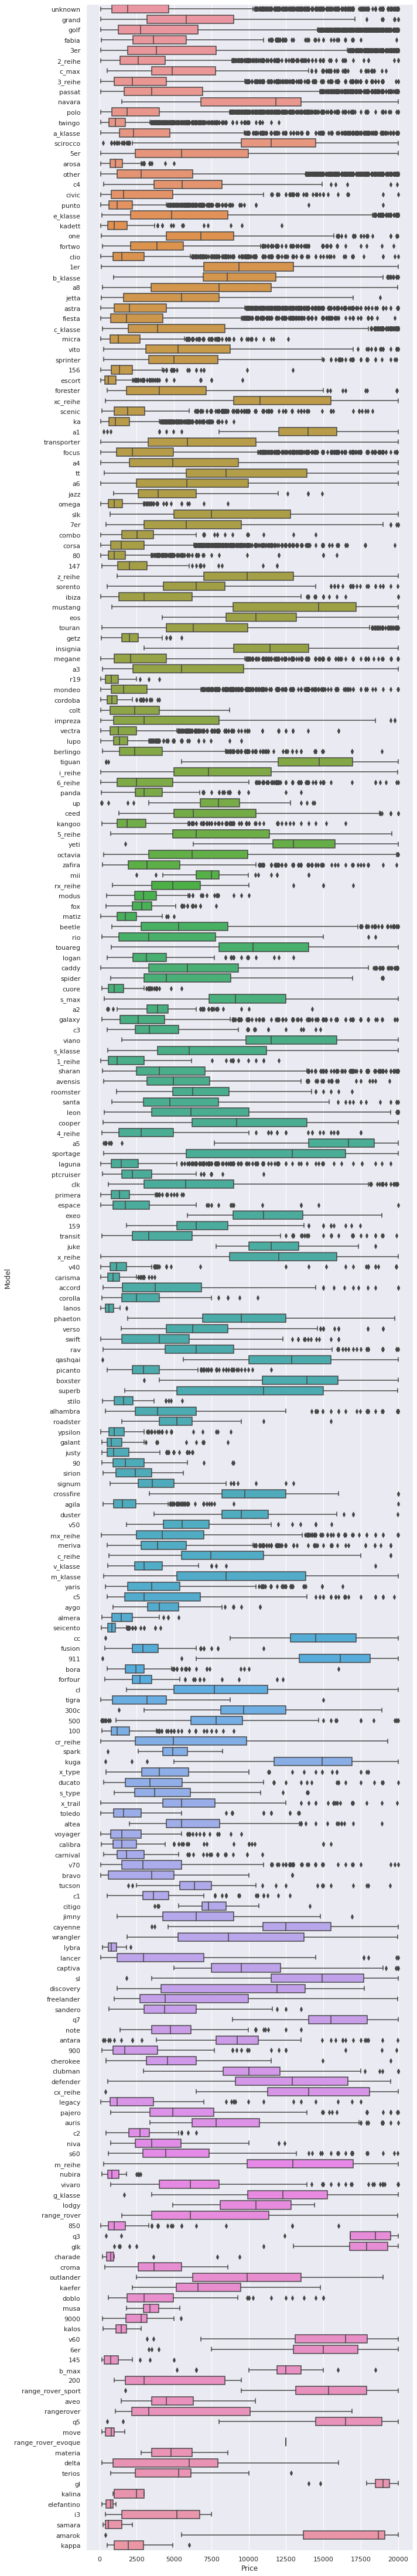

In [138]:
plt.figure(figsize = (10,80))
sns.boxplot(data=df,x='Price',y='Model');


Видим, что модель влияет на стоимость.

**Тип топлива (`'FuelType'`)**

In [139]:
multiv_stats(df,'FuelType')

,Price_mean,Price_median,Price_count,Price_frac
FuelType,,,,
All,4891.84,3200,287355,1.00
petrol,5010.36,3390,267122,0.93
unknown,2884.04,1500,14834,0.05
lpg,4257.10,3100,4635,0.02
cng,4765.44,4100,481,0.00
hybrid,10294.73,10900,199,0.00
other,3719.69,2250,52,0.00
electric,8429.69,9150,32,0.00


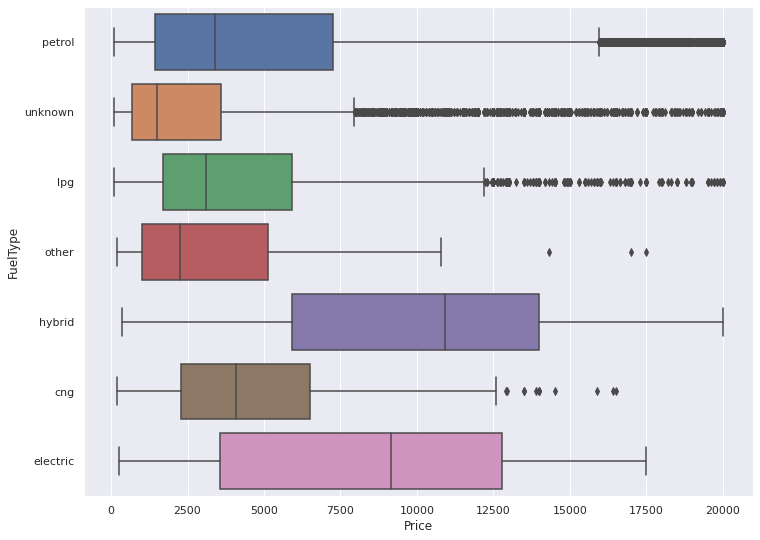

In [140]:
sns.boxplot(data=df,x='Price',y='FuelType');

**Производитель (`'Brand'`)** 

In [141]:
with pd.option_context("display.max_rows", 50):
    display(multiv_stats(df,'Brand'))

,Price_mean,Price_median,Price_count,Price_frac
Brand,,,,
All,4891.84,3200,287355,1.00
volkswagen,4884.62,3200,62313,0.22
bmw,6619.33,5499,31994,0.11
opel,3139.93,1899,30873,0.11
mercedes_benz,6283.93,4700,26432,0.09
audi,6731.13,5450,25370,0.09
ford,3529.69,1990,20208,0.07
renault,2589.80,1500,13743,0.05
peugeot,3433.84,2500,9150,0.03


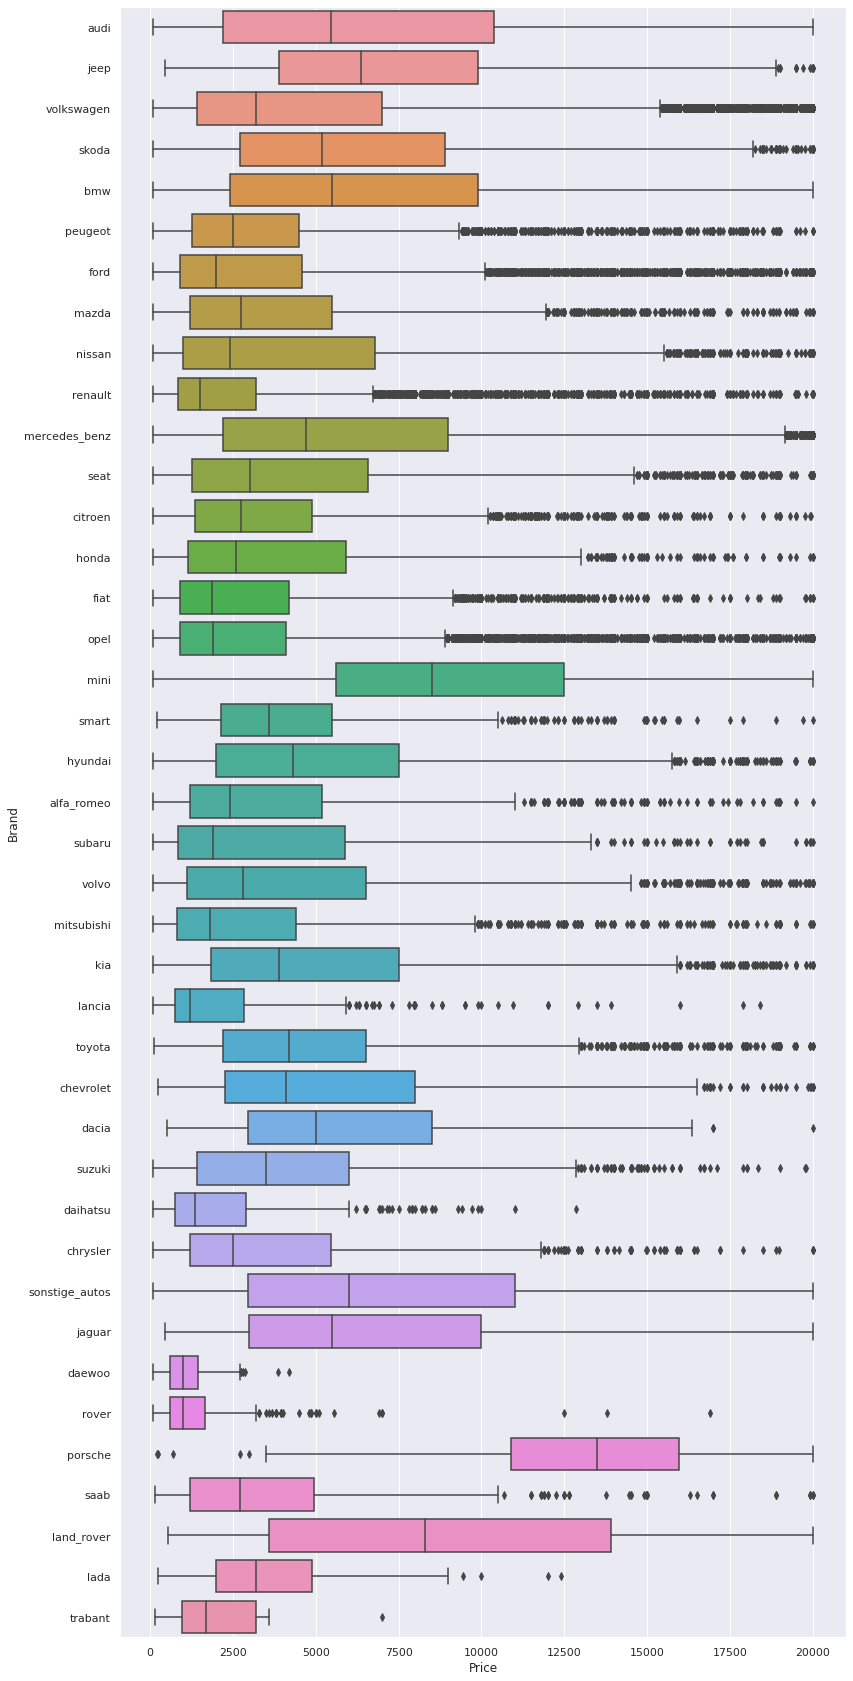

In [142]:
plt.figure(figsize = (13,30))
sns.boxplot(data=df,x='Price',y='Brand');

Бренд тоже влияет на стоимость модели, но в меньшей степени.

## Сравнение и выбор модели

In [143]:
# # Функция для вывода результата кросс валидации
# def print_cv_summary(cv_data,mean_col:str,std_col:str):
#     display(cv_data.head(10))

#     best_value = cv_data[mean_col].min()
#     best_iter = cv_data[mean_col].values.argmin()
#     best_std = cv_data[std_col][best_iter]

#     print(f'Best validation RMSE score : {best_value:.4f}±{best_std:.4f} on step {best_iter}')

Модели:
* Линейная регрессия
* Случайный лес
* Catboost
* LightGBM

Разделим данные на тренировочный и тестовые выборки

In [144]:
X = df.drop(columns=['Price'])
y = df['Price']

cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
num_cols = ['RegistrationYear','Power', 'Kilometer']

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

Подготовим данные, которые не используем в обучающем датасете

In [146]:
cols_to_delete = ['RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen']

df_400 = df_400.drop(columns=cols_to_delete).fillna('unknown')
df_400.loc[df_400['FuelType'] == 'gasoline','FuelType'] = 'petrol'

df_50 = df_50.drop(columns=cols_to_delete).fillna('unknown')
df_50.loc[df_50['FuelType'] == 'gasoline','FuelType'] = 'petrol'

df_older_1987 = df_older_1987.drop(columns=cols_to_delete).fillna('unknown')
df_older_1987.loc[df_older_1987['FuelType'] == 'gasoline','FuelType'] = 'petrol'

Кросс валидацию каждой модели обернем в функцию, чтобы питон очищал временные переменные внутри.

Нам необходимо выбрать модель опираясь на RMSE, скорость обучения и скорость предсказания.  
Для этого напишем функцию, которая кросс валидирует модель, считает RMSE, время обучения и предсказания.

In [147]:
def cv_and_timing(model_pipe,X,y):
    
    result = pd.DataFrame(columns=['rmse','learn_time','pred_time'])
    
    kfold = KFold(n_splits=2) ## <<<<< Здесь сделал всего 2 сплита, чтобы быстрее. Было 5.
    
    for train_index,val_index in kfold.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        learn_time_start = time.time()
        model_pipe.fit(X_train,y_train)
        learn_time_end = time.time()
        learn_time_delta = learn_time_end - learn_time_start
        
#         predict and scoring
        pred_time_start = time.time()
        y_pred = model_pipe.predict(X_val)
        pred_time_end = time.time()
        pred_time_delta = pred_time_end - pred_time_start
        
        rmse_current = mean_squared_error(y_val,y_pred,squared=False)
        
        temp_result = pd.DataFrame({'rmse':rmse_current,
                                    'learn_time':learn_time_delta,
                                    'pred_time':pred_time_delta},index=[0])
        result = pd.concat([result,temp_result])
    return result.reset_index(drop=True)

# lr_preprocessor = ColumnTransformer([('num',StandardScaler(),num_cols),
#                                     ('cat',OneHotEncoder(
# #                                         drop='first',
# #                                         Здесь мы не дропаем один столбец, потому что
# #                                         При крос вал скоре - ругается на неизвестную категорию,
# #                                         которую он заполняет нулями.
# #                                         Но это "место" уже занимает какая-то категория
# #                                         При дропе, поэтому, чтобы не путать модель,
# #                                         Отнесем неизвестные категории к 0 везде.
#                                         handle_unknown='ignore'),cat_cols)])

# lr_pipe = Pipeline([('preproc',lr_preprocessor),
#                      ('linreg',LinearRegression())])

# test(lr_pipe,X_train,y_train)

**Линейная регрессия**

In [148]:
def lf_scoring(X_train,y_train,num_cols,cat_cols):
    lr_preprocessor = ColumnTransformer([('num',StandardScaler(),num_cols),
                                        ('cat',OneHotEncoder(
    #                                         drop='first',
    #                                         Здесь мы не дропаем один столбец, потому что
    #                                         При крос вал скоре - ругается на неизвестную категорию,
    #                                         которую он заполняет нулями.
    #                                         Но это "место" уже занимает какая-то категория
    #                                         При дропе, поэтому, чтобы не путать модель,
    #                                         Отнесем неизвестные категории к 0 везде.
                                            handle_unknown='ignore'),cat_cols)])

    lr_pipe = Pipeline([('preproc',lr_preprocessor),
                         ('linreg',LinearRegression())])

#     lr_score = cross_val_score(lr_pipe,X_train,y_train,
#                                scoring='neg_root_mean_squared_error',cv=5,error_score='raise',verbose=999)
    lr_score = cv_and_timing(lr_pipe,X_train,y_train)
    return lr_score

lr_score = lf_scoring(X_train,y_train,num_cols,cat_cols)

In [149]:
def make_score_tab(score_df:pd.DataFrame,model_name:str) -> pd.DataFrame:
    result = pd.concat([score_df.mean(),score_df.std()]) 
    result = pd.DataFrame(result).T
    result.columns = ['rmse_mean', 'learn_time_mean', 'pred_time_mean', 'rmse_std', 'learn_time_std', 'pred_time_std']
    result = result[['rmse_mean','rmse_std','learn_time_mean','learn_time_std','pred_time_mean','pred_time_std']]
    result.index = [model_name]
    return result

scores = make_score_tab(lr_score,'linreg')

**Случайный лес**

In [150]:
def forest_scoring(X_train,y_train,cat_cols):
    forest = RandomForestRegressor(random_state=777)

    forest_preprocessor = ColumnTransformer([('cat',OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                  unknown_value=-1),cat_cols)]
                                            ,remainder='passthrough')

    forest_pipe = Pipeline([('preproc',forest_preprocessor),
                           ('forest',forest)])

#     forest_score = cross_val_score(forest_pipe,X_train,y_train,
#                                    scoring='neg_root_mean_squared_error',cv=5,error_score='raise',verbose=999,n_jobs=2)
    forest_score = cv_and_timing(forest_pipe,X_train,y_train)
    
    return forest_score

forest_score = forest_scoring(X_train,y_train,cat_cols)


# Обучение происходит долго, поэтому эмулируем.

# print('''[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
# [Parallel(n_jobs=2)]: Done   1 tasks      | elapsed: 66.9min
# [Parallel(n_jobs=2)]: Done   2 tasks      | elapsed: 66.9min
# [Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed: 145.8min remaining: 97.2min
# [Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 210.0min remaining:    0.0s
# [Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 210.0min finished''')

# forest_score_done = [-1573.5002631215812,
#                      -1591.7201070120868,
#                      -1572.8894887544222,
#                      -1555.4182148724833,
#                      -1558.2837759651777]

# # # print(forest_score_done)
# forest_score = np.array(forest_score_done)

In [151]:
scores = pd.concat([scores,make_score_tab(forest_score,'forest')]) 
scores

,rmse_mean,rmse_std,learn_time_mean,learn_time_std,pred_time_mean,pred_time_std
linreg,2335.53,3.30,15.68,0.06,0.48,0.16
forest,1600.37,15.19,24.45,0.12,3.68,0.05


**Catboost**

In [152]:
def catboost_scoring(X_train,y_train,cat_cols):
    
    catboost = cb.CatBoostRegressor(loss_function='RMSE')
#     params = catboost.get_params()
    
    result = pd.DataFrame(columns=['rmse','learn_time','pred_time'])
    
    kfold = KFold(n_splits=2) ## <<<<< Здесь сделал всего 2 сплита, чтобы быстрее. Было 5.
    
    for train_index,val_index in kfold.split(X_train):
        X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        
        data_pool = cb.Pool(X_train_cv,y_train_cv,cat_features=cat_cols)
        
        learn_time_start = time.time()
        catboost.fit(data_pool,verbose=0)
        learn_time_end = time.time()
        learn_time_delta = learn_time_end - learn_time_start
        
#         predict and scoring
        pred_time_start = time.time()
        y_pred = catboost.predict(X_val_cv)
        pred_time_end = time.time()
        pred_time_delta = pred_time_end - pred_time_start
        
        rmse_current = mean_squared_error(y_val_cv,y_pred,squared=False)
        
        temp_result = pd.DataFrame({'rmse':rmse_current,
                                    'learn_time':learn_time_delta,
                                    'pred_time':pred_time_delta},index=[0])
        result = pd.concat([result,temp_result])
    return result.reset_index(drop=True)
    
#     cb_cv = cb.cv(data_pool,params, fold_count=5, plot=True,verbose=False)
#     return cb_cv

cb_cv = catboost_scoring(X_train,y_train,cat_cols)

In [153]:
scores = pd.concat([scores,make_score_tab(cb_cv,'catboost')]) 
scores

,rmse_mean,rmse_std,learn_time_mean,learn_time_std,pred_time_mean,pred_time_std
linreg,2335.53,3.30,15.68,0.06,0.48,0.16
forest,1600.37,15.19,24.45,0.12,3.68,0.05
catboost,1564.68,20.94,147.23,21.30,1.57,0.88


**LightGBM**

In [ ]:
def ltb_scoring(X_train,y_train,cat_cols):
    
    X_train[cat_cols] = X_train[cat_cols].astype('category')
    
#     ltb_dataset = ltb.Dataset(X_train,y_train,
#                               categorical_feature=cat_cols
#                              )

#     params = {'objective':'regression',
#              'metric':'rmse',
#              'num_iterations': 1000,
#              'verbose':-1}
    
    model = ltb.LGBMRegressor(
                          n_estimators= 1000, # Чтобы также как в катбусте
                         )

    result = pd.DataFrame(columns=['rmse','learn_time','pred_time'])
    
    kfold = KFold(n_splits=2) ## <<<<< Здесь сделал всего 2 сплита, чтобы быстрее. Было 5.

    for train_index,val_index in kfold.split(X_train):

        X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

        learn_time_start = time.time()
        model.fit(X_train_cv,y_train_cv,categorical_feature=cat_cols)
        learn_time_end = time.time()
        learn_time_delta = learn_time_end - learn_time_start

#         predict and scoring
        pred_time_start = time.time()
        y_pred = model.predict(X_val_cv)
        pred_time_end = time.time()
        pred_time_delta = pred_time_end - pred_time_start

        rmse_current = mean_squared_error(y_val_cv,y_pred,squared=False)
        
        temp_result = pd.DataFrame({'rmse':rmse_current,
                                    'learn_time':learn_time_delta,
                                    'pred_time':pred_time_delta},index=[0])
        # display(temp_result)
        result = pd.concat([result,temp_result])
    return result


ltb_cv = ltb_scoring(X_train,y_train,cat_cols)

In [ ]:
scores = pd.concat([scores,make_score_tab(ltb_cv,'lgbm')]) 
scores

Построим график и сравним среднюю результативность моделей по 5 (временно 2м) фолдам и стандартное отклонение.

In [ ]:
ax = sns.barplot(data=scores,y='rmse_mean',x=scores.index)
ax.errorbar(data=scores, x=scores.index, y='rmse_mean', yerr='rmse_std', ls='', lw=3, color='black')
plt.ylim(1400,1600)
plt.show()

Сравним скорость обучения моделей на графике.

In [ ]:
ax = sns.barplot(data=scores,y='learn_time_mean',x=scores.index)
ax.errorbar(data=scores, x=scores.index, y='learn_time_mean', yerr='learn_time_std', ls='', lw=3, color='black')
# plt.ylim(1400,1600)
plt.show()

In [ ]:
ax = sns.barplot(data=scores,y='learn_time_mean',x=scores.index)
ax.errorbar(data=scores, x=scores.index, y='learn_time_mean', yerr='learn_time_std', ls='', lw=3, color='black')
plt.ylim(0,10)
plt.show()

Сравним скорость предсказания моделей.

In [ ]:
ax = sns.barplot(data=scores,y='pred_time_mean',x=scores.index)
ax.errorbar(data=scores, x=scores.index, y='pred_time_mean', yerr='pred_time_std', ls='', lw=3, color='black')
plt.ylim(0,2)
plt.show()

* `LightGBM` предпочтительнее по скорости и точности.

## Подбор гиперпараметров для LightGBM

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [ ]:
def hyperopt_lgbm_tuning(X_train,y_train,cat_cols,seed=2):
    
    X_train[cat_cols] = X_train[cat_cols].astype('category')
    
    dataset = ltb.Dataset(X_train,y_train,
                          categorical_feature=cat_cols,
                          free_raw_data=False
                             )
    
    search_space = {'num_leaves': hp.quniform('num_leaves',1869,1871,1) , # Здесь было hp.quniform('num_leaves',20,3000,1)
                    # should be smaller that 2^(max_depth), overwise could cause overfitting. Lets try 10*(max_depth)
                    # 'min_data_in_leaf': hp.quniform('min_data_in_leaf',100,2100,1) , # optimal value depends on n of training samples and num_leaves. Too large may cause under-fitting and avoides too deep tree. *100 or *1000 is suggested
                    # 'max_depth': hp.quniform('max_depth',3,150,1), #
                    # 'n_estimators': hp.quniform('n_estimators',10,5000,100),
                    # 'learning_rate': hp.uniform('learning_rate',0.01,0.3) , # small may cause overfitting [0.01,0.3]
                     }


    def objective(params,dataset):

        for k,v in params.items():
            if k != 'learning_rate':
                params[k] = int(v)

        # Фиксированные параметры
        cv_fixed_params = {'objective':'regression',
             'metric':'rmse',
             'verbose':-1}

        params.update(cv_fixed_params)

        score = ltb.cv(params,dataset,stratified=False)
        return {'loss': min(score['rmse-mean']), 'params': params, 'status': STATUS_OK}

    trials = Trials()
    best = fmin( 
              # функция для оптимизации  
                fn=partial(objective, dataset=dataset),
              # пространство поиска гиперпараметров  
                space=search_space,
              # алгоритм поиска
                algo=tpe.suggest,
              # число итераций 
              # (можно ещё указать и время поиска) 
                max_evals=1, # Здесь было 100, уменьшил до 1
              # куда сохранять историю поиска
                trials=trials,
              # random_state  
                rstate = np.random.default_rng(seed)
            )    
    
    return trials

trials = hyperopt_lgbm_tuning(X_train,y_train,cat_cols,seed=2)

In [ ]:
def df_results(hp_results):
    results = pd.DataFrame([{**x, **x['params']} for x in  hp_results])
    results = results.drop(labels=['status', 'params', 'objective', 'metric', 'verbose'], axis=1)
    results = results.sort_values(by=['loss'])
    display(results.head())
    best_score = results['loss'].argmin()
    best_params = results.loc[best_score].to_dict()
    best_params.pop('loss')
    return results, best_params

results, best_params = df_results(trials.results)
best_params

In [ ]:
# Лучшие параметры по результатам 100 оценок
best_params_ = {'learning_rate': 0.2753834528623228,
                 'max_depth': 121,
                 'min_data_in_leaf': 796,
                 'n_estimators': 1200,
                 'num_leaves': 1870}

In [ ]:
def lgtm_fit(X_train,y_train,best_params_,cat_cols):
    X_train[cat_cols] = X_train[cat_cols].astype('category')
    
    model = ltb.LGBMRegressor(learning_rate=best_params_['learning_rate'],
                              max_depth=best_params_['max_depth'],
                             min_child_samples=best_params_['min_data_in_leaf'],
                              n_estimators=best_params_['n_estimators'],
                              num_leaves=best_params_['num_leaves']
                             )
    model.fit(X_train,y_train,categorical_feature=cat_cols)
    return model


model = lgtm_fit(X_train,y_train,best_params_,cat_cols)

Оценим LightGBM на тестовых данных. Посчитаем RMSE и скорость предсказания.

In [ ]:
X_test_preprocessed = X_test.copy()
X_test_preprocessed[cat_cols] = X_test_preprocessed[cat_cols].astype('category')
pred_time_start = time.time()
y_pred = model.predict(X_test_preprocessed)
pred_time_end = time.time()
pred_time_delta = pred_time_end - pred_time_start
lgtm_test_RMSE = mean_squared_error(y_test,y_pred,squared=False)

In [ ]:
print(f'RMSE на тестовой выборке: {lgtm_test_RMSE:.2f}')
print(f'Скорость предсказания: {pred_time_delta:.2f} сек.')

In [ ]:
# def anom_test(df,model,cat_cols):
#     X = df.drop(columns=['Price'])
#     y_true = df['Price']
#     X[cat_cols] = X[cat_cols].astype('category')
#     y_pred = model.predict(X)
#     return mean_squared_error(y_true,y_pred,squared=False)

# more_400 = anom_test(df_400,model,cat_cols)
# less_50 = anom_test(df_50,model,cat_cols)
# older_1987 = anom_test(df_older_1987,model,cat_cols)
# # year_outliers = anom_test(df_reg_year_outliers,model,cat_cols)
# print(f'RMSE на авто с мощностью > 400: {more_400}')
# print(f'RMSE на авто с мощностью < 50: {less_50}')
# print(older_1987)

## Исследование важности признаков

In [ ]:
# import shap
# # # TO DO
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
# shap.summary_plot(shap_values, X_train)

## Общий вывод

Это игрушечные, синтетические данные. С учетом этого:
* был обработан целевой признак, удалены выбросы и мусорные значения.
* удалены столбцы с информацией о различных датах, потому что они не представляли ценности для обучения и содержали противоречивые данные
* в обучении моделей были использованы следующие признаки:
    * категориальные `'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'`
    * численные `'RegistrationYear','Power'`, 'Kilometer'

Сравнили модели:
* Линейная регрессия
* Случайный лес
* Catboost
* LightGBM

Целевая метрика: `RMSE`  
Сравнивали скорость обучения и скорость предсказания моделей.

In [ ]:
scores

LightGBM оказался точнее при самой быстрой скорости обучения, не считая линейной регрессии, которая выдала слишком высокий RMSE.

In [ ]:
print(f'RMSE на тестовой выборке: {lgtm_test_RMSE:.2f}')
print(f'Скорость предсказания: {pred_time_delta:.2f} сек.')